In [ ]:
from IPython.display import clear_output
import os,cv2,random,torch,torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
AllClasses =['children','adults']


class DataProcess(torch.utils.data.Dataset):
    def __init__(self, ImagesPath, ImageTransformer):
        global AllClasses
        def GetImage(Class):
            images = [x for x in os.listdir(ImagesPath[Class])]
            print(f'Found {len(images)} {Class} examples')
            return images
        
        self.images = {}
        self.Classes = AllClasses
        
        for Class in self.Classes:
            self.images[Class] = GetImage(Class)
            
        self.ImagesPath = ImagesPath
        self.ImageTransformer = ImageTransformer
    def __len__(self):
        return sum([len(self.images[Class]) for Class in self.Classes])
    def __getitem__(self, index):
        Class = random.choice(self.Classes)
        index = index % len(self.images[Class])
        NameOfPicture = self.images[Class][index]
        PathOfPicture = os.path.join(self.ImagesPath[Class], NameOfPicture)
        image = Image.open(PathOfPicture).convert('RGB')
        
        return self.ImageTransformer(image), self.Classes.index(Class)

def AccCalc(LabelsValues,OutputValues) : 
  _,PredictedValues = torch.max(OutputValues, 1)
  return sum((PredictedValues == LabelsValues).numpy())

In [ ]:
AllImages = {}
SavedImages = 0
Path = '/content/drive/MyDrive/AgeClassification/train/'
for folder in os.listdir(Path) : 
  ThisPath = os.path.join(Path,folder)
  AllImages[folder] = []
  for image in os.listdir(ThisPath) : 
    SavedImages+=1
    AllImages[folder].append(os.path.join(ThisPath,image))
AllImages

{'adults': ['/content/drive/MyDrive/AgeClassification/train/adults/388 (1).jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/176.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/158.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/155.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/204.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/112.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/339.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/214.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/263.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/145.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/167.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/376.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/85.jpg',
  '/content/drive/MyDrive/AgeClassification/train/adults/195.jpg',
  '/content/drive/MyDrive/AgeClassification/train

In [ ]:
len(AllImages.keys()),SavedImages

(2, 690)

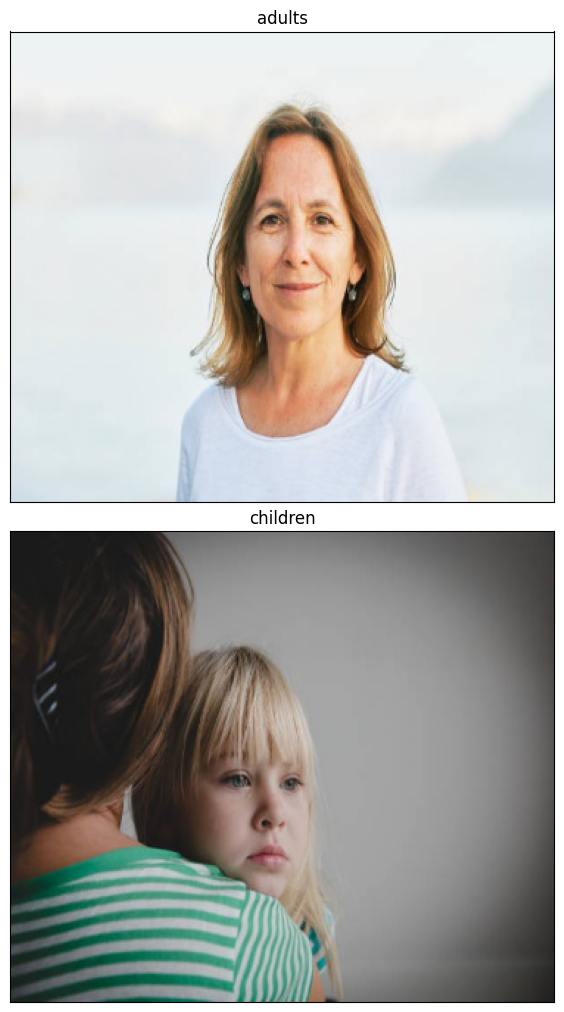

In [ ]:
def ShowImages() : 
  global AllImages

  fig, ax = plt.subplots(2, 1, figsize=(20,10))  
  fig.tight_layout(pad=0.010)
  for i in range(len(ax)): 
    im = np.random.choice(AllImages[list(AllImages.keys())[i]])
    ax[i].imshow(plt.imread(im))
    ax[i].set_title(list(AllImages.keys())[i])

  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ShowImages()        

In [ ]:
SavedImages,TrainingDataSize,TestingDataSize=0,0,0
ThisModel,ThisLossFunction ,ThisOptimizer = None,None,None
ThisTransformer = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(50,50)),
                                                #TODO: torchvision. transforms.Grayscale(num_output_channels=1),
                                                #TODO:  torchvision. transforms.GaussianBlur(kernel_size=501),
                                                  torchvision.transforms.ToTensor()])

In [ ]:
ImagesPath = {i:os.path.join(r'/content/drive/MyDrive/AgeClassification/train/',i) for i in AllClasses}


ImagesPath = {'children' : '/content/drive/MyDrive/AgeClassification/train/children',
              'adults' : '/content/drive/MyDrive/AgeClassification/train/adults'}


ProcessedData = DataProcess(ImagesPath, ThisTransformer)

TrainingDataSize = 0.8

TrainingSize = int(TrainingDataSize * len(ProcessedData))
TestingSize = len(ProcessedData) - TrainingSize

TrainingData, TestingData = torch.utils.data.random_split(ProcessedData, [TrainingSize, TestingSize])
TrainingDataSize,TestingDataSize=len(TrainingData), len(TestingData)
print("Length of train set   :  ", len(TrainingData))
print("Length of test set    :  ", len(TestingData))


Found 340 children examples
Found 350 adults examples
Length of train set   :   552
Length of test set    :   138


In [ ]:
BatchSize = 10

TrainingDataLength = torch.utils.data.DataLoader(TrainingData, batch_size = BatchSize, shuffle = True)
TestingDataLength = torch.utils.data.DataLoader(TestingData, batch_size=BatchSize, shuffle=True)


print("Length of training batches", len(TrainingDataLength))
print("Lentgth of test batches", len(TestingDataLength))


Length of training batches 56
Lentgth of test batches 14


In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.00001)  

For Epoch Number 30
---------------------------------------------
Train Loss is 0.09 & Train Accuracy is 0.98 
Test Loss is 0.27 & Test Accuracy is 0.91


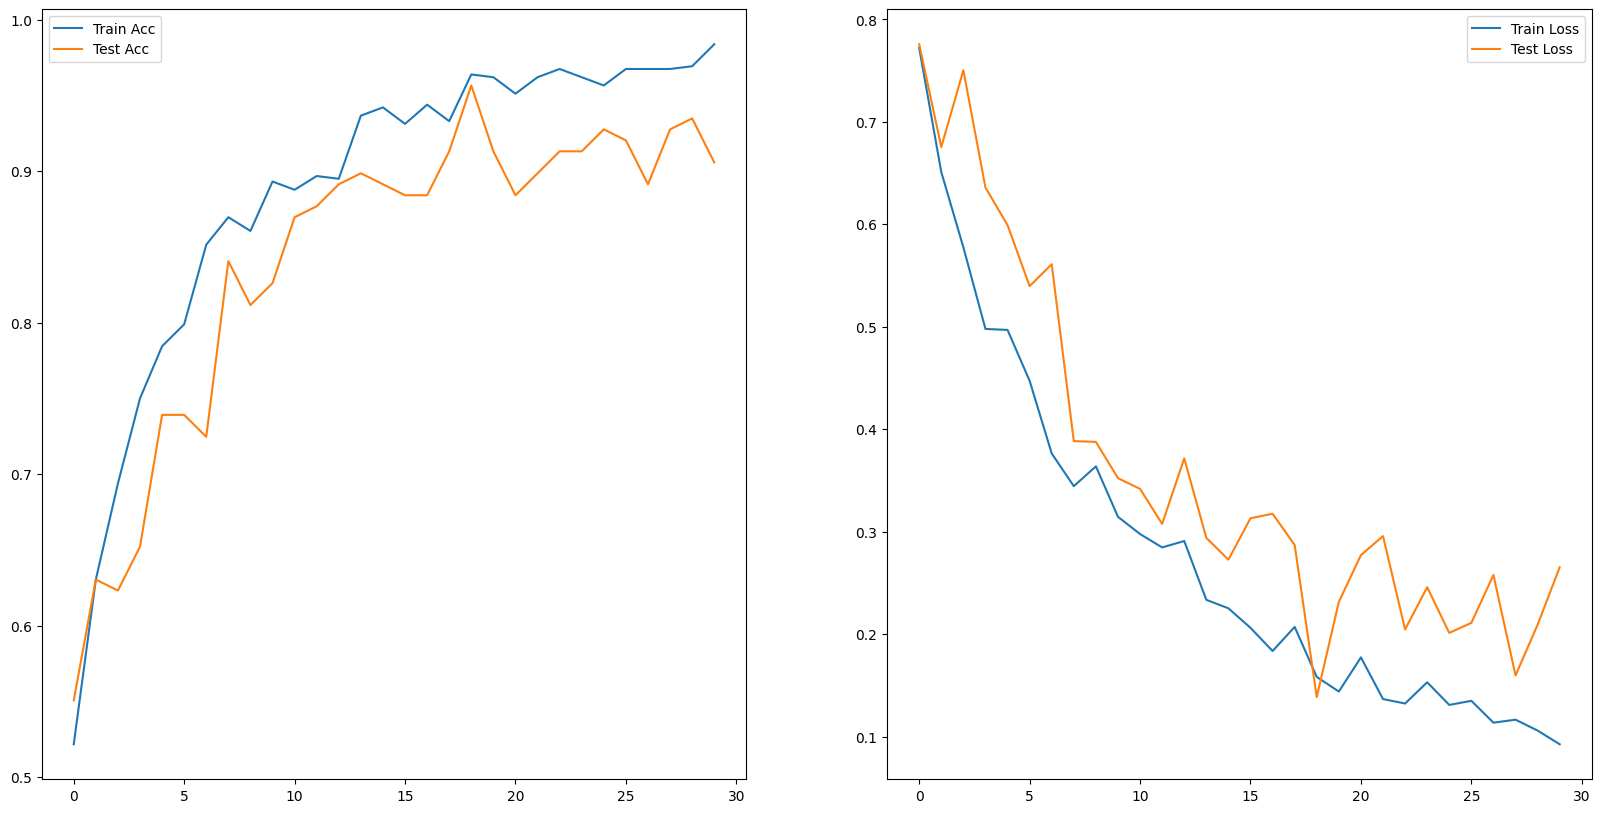

CPU times: user 13min 16s, sys: 58.1 s, total: 14min 14s
Wall time: 16min 50s


In [ ]:
%%time
NumberOfEpochs = 30
ThisModel = resnet18
 
ThisOptimizer = optimizer

ThisLossFunction=loss_fn

AccuracyTraining,AccuracyTesting,LossTraining,LossTesting = [],[],[],[]
for j in range(NumberOfEpochs):
  print(j)
  TrainLoss,TestLoss,TrainAccuracy,TestAccuracy  = 0,0,0,0
  ThisModel.train()
  i=0
  for X,y in TrainingDataLength:
    i+=1
    ThisOptimizer.zero_grad()
    ThisOutput = ThisModel(X)
    ThisLoss = ThisLossFunction(ThisOutput,y)
    ThisLoss.backward()
    ThisOptimizer.step()
    TrainLoss += ThisLoss.item()
    TrainAccuracy += AccCalc(y,ThisOutput)
  TrainLoss /=i
  TrainAccuracy /=TrainingDataSize
  
  AccuracyTraining.append(TrainAccuracy)
  LossTraining.append(TrainLoss)
  
  ThisModel.eval()
  i=0
  for X,y in TestingDataLength:
    i+=1
    ThisOutput = ThisModel(X)
    ThisLoss = ThisLossFunction(ThisOutput,y)
    TestLoss += ThisLoss.item()
    TestAccuracy += AccCalc(y,ThisOutput)
  
  TestLoss/=i
  TestAccuracy /=TestingDataSize
  AccuracyTesting.append(TestAccuracy)
  LossTesting.append(TestLoss)
  
  clear_output(wait=True)
  print(f'For Epoch Number {j+1}')
  print('---------------------------------------------')
  print(f'Train Loss is {np.round(TrainLoss,2)} & Train Accuracy is {np.round(TrainAccuracy,2)} ')
  print(f'Test Loss is {np.round(TestLoss,2)} & Test Accuracy is {np.round(TestAccuracy,2)}')
  torch.save(ThisModel, f"/content/drive/MyDrive/AgeClassificationV4-{j+1}.h5")
  plt.figure(figsize=(20,10))
  XValue = [k for k in range(j+1)]
  plt.subplot(1,2,1)
  plt.plot(XValue,AccuracyTraining,label='Train Acc')
  plt.plot(XValue,AccuracyTesting,label='Test Acc')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(XValue,LossTraining,label='Train Loss')
  plt.plot(XValue,LossTesting,label='Test Loss')
  plt.legend()
  plt.show()
 

In [ ]:
from IPython.display import clear_output
import os,cv2,random,torch,torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
AllImages = {}
SavedImages = 0
Path = '/content/drive/MyDrive/AgeClassification/train/'
for folder in ['children', 'adults'] : 
  ThisPath = os.path.join(Path,folder)
  AllImages[folder] = []
  for image in os.listdir(ThisPath) : 
    SavedImages+=1
    AllImages[folder].append(os.path.join(ThisPath,image))
AllImages

{'children': ['/content/drive/MyDrive/AgeClassification/train/children/104.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/102.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/100.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/106.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/101.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/111.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/112.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/108.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/113.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/105.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/110.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/107.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/109.jpg',
  '/content/drive/MyDrive/AgeClassification/train/children/103.jpg',
  '/content/drive/MyDr

In [ ]:
len(AllImages.keys()),SavedImages

(2, 3)

In [ ]:
AllClasses =['children', 'adults']


class DataProcess(torch.utils.data.Dataset):
    def __init__(self, ImagesPath, ImageTransformer):
        global AllClasses
        def GetImage(Class):
            images = [x for x in os.listdir(ImagesPath[Class])]
            print(f'Found {len(images)} {Class} examples')
            return images
        
        self.images = {}
        self.Classes = AllClasses
        
        for Class in self.Classes:
            self.images[Class] = GetImage(Class)
            
        self.ImagesPath = ImagesPath
        self.ImageTransformer = ImageTransformer
    def __len__(self):
        return sum([len(self.images[Class]) for Class in self.Classes])
    def __getitem__(self, index):
        Class = random.choice(self.Classes)
        index = index % len(self.images[Class])
        NameOfPicture = self.images[Class][index]
        PathOfPicture = os.path.join(self.ImagesPath[Class], NameOfPicture)
        image = Image.open(PathOfPicture).convert('RGB')
        
        return self.ImageTransformer(image), self.Classes.index(Class)

def AccCalc(LabelsValues,OutputValues) : 
  _,PredictedValues = torch.max(OutputValues, 1)
  return sum((PredictedValues == LabelsValues).numpy())

In [ ]:
SavedImages,TrainingDataSize,TestingDataSize=0,0,0
ThisModel,ThisLossFunction ,ThisOptimizer = None,None,None
ThisTransformer = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(50,50)),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor()])

In [ ]:
ImagesPath = {i:os.path.join(r'/content/drive/MyDrive/AgeClassification/test1/',i) for i in AllClasses}

ProcessedData = DataProcess(ImagesPath, ThisTransformer)

TrainingDataSize = 0.8

TrainingSize = int(TrainingDataSize * len(ProcessedData))
TestingSize = len(ProcessedData) - TrainingSize

TrainingData, TestingData = torch.utils.data.random_split(ProcessedData, [TrainingSize, TestingSize])
TrainingDataSize,TestingDataSize=len(TrainingData), len(TestingData)
print("Length of train set   :  ", len(TrainingData))
print("Length of test set    :  ", len(TestingData))

Found 3 children examples
Found 0 adults examples
Length of train set   :   2
Length of test set    :   1


In [ ]:
BatchSize = 10

TrainingDataLength = torch.utils.data.DataLoader(TrainingData, batch_size = BatchSize, shuffle = True)
TestingDataLength = torch.utils.data.DataLoader(TestingData, batch_size=BatchSize, shuffle=True)

print("Length of training batches", len(TrainingDataLength))
print("Lentgth of test batches", len(TestingDataLength))

Length of training batches 1
Lentgth of test batches 1


In [ ]:
ThisModel = torch.load('/content/drive/MyDrive/AgeClassificationV4-30.h5')

In [ ]:
i=0
AllYValue,AllOutput = [],[]
ThisModel.eval()
ThisLossFunction = torch.nn.CrossEntropyLoss()
TestLoss,TestAccuracy  = 0,0
for X,y in TestingDataLength:
  i+=1
  # if i ==50 : break
  if i%50==0 : print(i)
  ThisOutput = ThisModel(X)
  AllYValue.extend(y)
  _,PredictedValues = torch.max(ThisOutput, 1)
  AllOutput.extend([int(i) for i in PredictedValues])
  ThisLoss = ThisLossFunction(ThisOutput,y)
  TestLoss += ThisLoss.item()
  TestAccuracy += AccCalc(y,ThisOutput)
z=0
for a,b in zip(AllOutput,[int(i) for i in AllYValue]) : 
  if a==b : z+=1
z/len(AllOutput)

0.9130434782608695

In [ ]:
TestLoss/i,TestAccuracy/i*0.10

(0.2771224713485156, 0.9071428571428571)

In [ ]:
print(f'Model Accuracy is {np.round(TestAccuracy/i*0.10,2)} and loss is {np.round(TestLoss/i,2)}')

Model Accuracy is 0.91 and loss is 0.28


In [ ]:
AllYValue = [int(i) for i in AllYValue]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(AllOutput,AllYValue)

array([[60,  3],
       [ 8, 67]])

In [ ]:
print(classification_report(AllOutput,AllYValue))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        63
           1       0.96      0.89      0.92        75

    accuracy                           0.92       138
   macro avg       0.92      0.92      0.92       138
weighted avg       0.92      0.92      0.92       138

